In [86]:
%matplotlib inline

# Dealing with Sky maps and Galaxy candidates

Simple way to deal with sky maps and probability distributions for a line of sight. Based on paper at: https://arxiv.org/pdf/1605.04242v3.pdf

In [87]:
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm



In [6]:
from astropy.utils.data import download_file
url = ('https://dcc.ligo.org/P1500071/public/18951_bayestar.fits.gz')
filename = download_file(url, cache=True)

In [7]:
prob = hp.read_map(filename)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [9]:
prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [10]:
prob, distmu, distsigma, distnorm = hp.read_map(
... filename, field=range(4))

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [11]:
npix = len(prob)
nside = hp.npix2nside(npix)

In [12]:
ra, dec = 137.8, -39.9

In [13]:
theta = 0.5*np.pi - np.deg2rad(dec)
phi = np.deg2rad(ra)

In [14]:
ipix = hp.ang2pix(nside, theta, phi)
ipix

2582288

In [15]:
pixarea = hp.nside2pixarea(nside)
pixarea

3.994741635118857e-06

In [16]:
pixarea_deg2 = hp.nside2pixarea(nside, degrees=True)
pixarea_deg2

0.013113963206424481

In [17]:
r = np.linspace(0, 150)

In [20]:
dp_dr = r**2*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r)

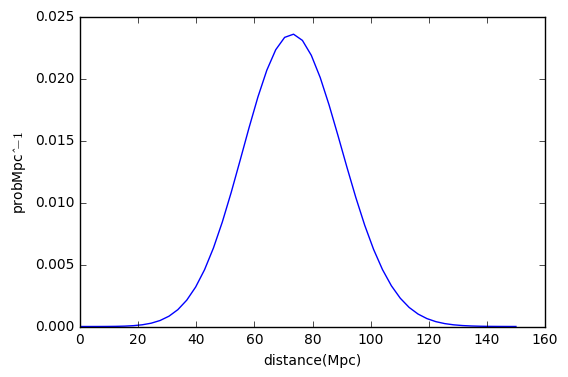

In [21]:
plt.plot(r, dp_dr)
plt.xlabel('distance(Mpc)')
plt.ylabel('probMpc$ˆ{-1}$')
plt.show()

In [22]:
r = 74.8

In [23]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r) / pixarea
dp_dV

3.1173200109121657e-05

In [24]:
r = np.linspace(0, 150)
dp_dr = [np.sum(prob*rr**2*distnorm*norm(distmu, distsigma).pdf(rr)) for rr in r]

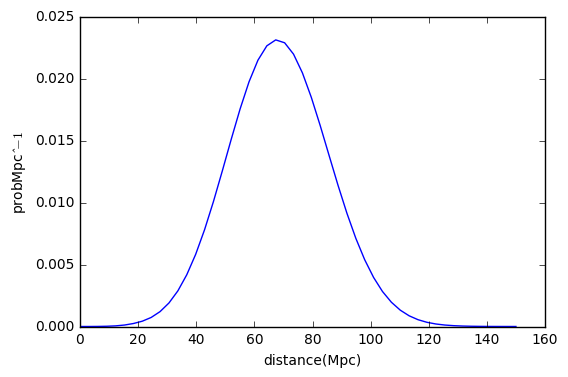

In [25]:
plt.plot(r, dp_dr)
plt.xlabel('distance(Mpc)')
plt.ylabel('probMpc$ˆ{-1}$')
plt.show()

## 3D Sky Maps And Galaxy Candidates

In [56]:
from matplotlib import pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Column
import astropy.units as u
import astropy.constants as c
from matplotlib import colors
import math as m
import numpy as np

In [57]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
cat, = Vizier.get_catalogs('J/ApJS/199/26/table3')
len(cat)

44599

In [58]:
from scipy.special import gammaincinv
completeness = 0.5
alpha = -1.0
MK_star = -23.55
MK_max = MK_star + 2.5*np.log10(gammaincinv(alpha + 2, completeness))
MK_max

-23.947936347387156

In [25]:

z = (u.Quantity(cat['cz']) / c.c).to(u.dimensionless_unscaled)
MK = cat['Ktmag'] - cosmo.distmod(z)
keep = (z >= 0) & (MK <= MK_max)
#cat = cat[keep]
z = z[keep]

print(len(cat))

44599


/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/student/student_i4/miniconda3/lib/python3.5/site-packages/astropy/cosmology/core.py:1414: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


In [49]:
r = cosmo.luminosity_distance(z).to('Mpc').value
print(r)

[   3.50771182    7.90223638    8.13372026 ...,  153.74754559  415.37987309
  197.41344517]


In [26]:
print(cat[1]['_RAJ2000'])

cords_ra = []
cords_dec = []
cords_dec_sin = []
cords = []
for cand in cat:
    cords_ra.append(float(cand['_RAJ2000']))
    cords_dec_sin.append(m.sin(m.radians(float(cand['_DEJ2000']))))
    cords_dec.append(float(cand['_DEJ2000']))
    cords.append([float(cand['_RAJ2000']), float(cand['_DEJ2000']), cand['SimbadName']])



11.88806


In [27]:
print(cords_dec[0:10])

[41.26875, -25.2888, 69.06526, -43.01871, -49.4679, 30.65994, 69.6797, 68.09611, -29.86576, -11.62307]


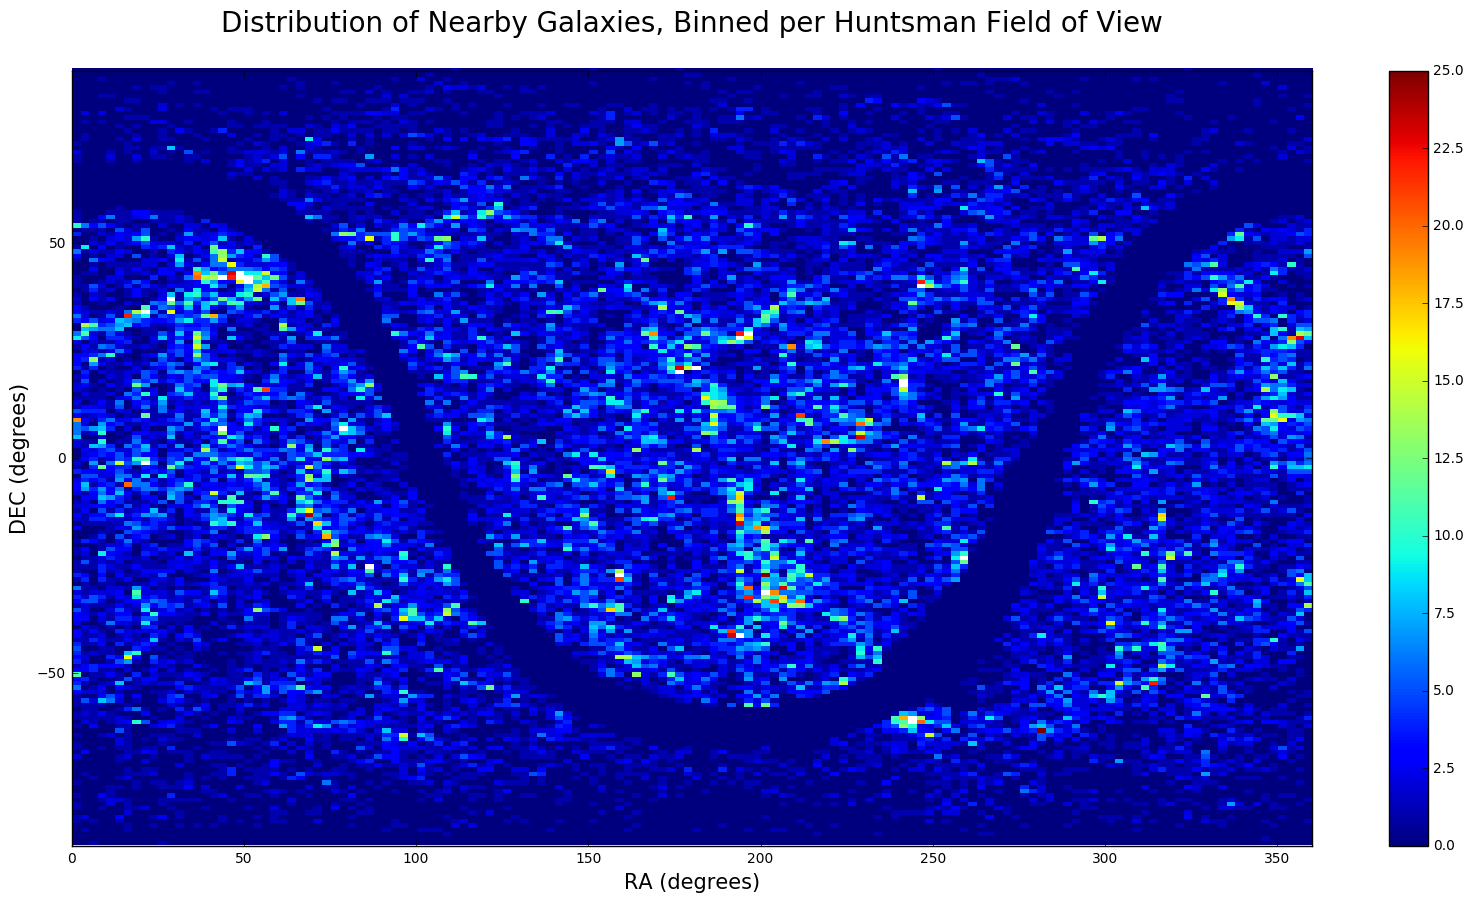

In [48]:
sin_dec = np.linspace(0,1,29)
ra_deg = np.linspace(0,360,144)

plt.figure(figsize=(20,10))
plt.hist2d(cords_ra, cords_dec, bins = [144, 180],cmax=25, range=np.array([(0,360), (-90,90)]))

plt.xlabel('RA (degrees)', fontsize = 15)
plt.ylabel('DEC (degrees)', fontsize = 15)
plt.title('Distribution of Nearby Galaxies, Binned per Huntsman Field of View\n', fontsize = 20)
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.colorbar()
plt.show()

In [35]:
from astropy.coordinates import SkyCoord
from astropy import coordinates

c = SkyCoord('00h54m53.479s -37d41m03.77s', frame='fk5')
print(c.to_string('decimal'))
max_ra = c.ra.deg + 1.3
min_ra = c.ra.deg - 1.3
max_dec = c.dec.deg + 1.0
min_dec = c.dec.deg - 1.0


print(max_ra,max_dec,min_ra,min_dec)

13.7228 -37.6844
15.022829166666666 -36.68438055555555 12.422829166666665 -38.68438055555555


In [36]:
in_view_of_NGC300 = []
ra_in_view = []
dec_in_view = []
for cord in cords:
    if cord[0] <= max_ra and cord[0] >= min_ra and cord[1] <= max_dec and cord[1] >= min_dec:
        print(str(cord[2]) + ', RA: '+ str(cord[0])+', DEC: '+str(cord[1]))
        #print(cord[0])
        #print(cord[1])

        in_view_of_NGC300.append(cord)
        ra_in_view.append(cord[0])
        dec_in_view.append(cord[1])
        
        
if c.ra.deg <= max_ra and c.ra.deg >= min_ra and c.dec.deg <= max_dec and c.dec.deg >= min_dec:
    print('yes')

b'2MASX J00545347-3741037', RA: 13.72283, DEC: -37.68438
b'2MASX J00554650-3724275', RA: 13.94374, DEC: -37.40775
b'2MASX J00513111-3739192', RA: 12.8797, DEC: -37.6554
b'2MASX J00574364-3733432', RA: 14.43187, DEC: -37.562
yes


NGC 300 identifiers:


 NGC 300 	
 ESO 295-20 	
 LEDA 3238 	SPB 17
AM 0052-375 	
ESO-LV 295-0200 [Full data in the catalogue ESO] 	
2MASX J00545347-3741037 [Full data in the catalogue 2MASX] 

[CHM2007]LDC 26 J005453.47-3741037

6dFGS 

gJ005453.4-374104 	
HIPASS J0054-37 [Full data in the catalogue HIPASS] 	
MCG-06-03-005 	
[M98c] 005232.0-375712
6dFGS gJ005454.9-374107 	
IRAS 00525-3757 [Full data in the catalogue IRAS] 	
SGC 005232-3757.2 	
[VDD93] 3


---------------------------------------

As we can see none of these are candidates for NGC 300. Coords for NGC 300 do make the search. This means it's not in the catalogue????

In [37]:
Simbad_names = ['NGC 300', 'ESO 295-20', 'LEDA 3238', 'SPB 17', 'AM 0052-375', 'ESO-LV 295-0200',
                '2MASX J00545347-3741037', '[CHM2007] LDC 26 J005453.47-3741037', '6dFGS gJ005453.4-374104',
                'HIPASS J0054-37', 'MCG-06-03-005', '[M98c] 005232.0-375712', '6dFGS gJ005454.9-374107', 
                'IRAS 00525-3757', 'SGC 005232-3757.2', '[VDD93] 3']

for cord in cords:
    if abs(cord[0] - c.ra.deg) <= 0.1 and abs(cord[1] - c.dec.deg) <= 0.1:
        print('cords found')
    
    name = str(cord[2])
    #print(type(name))
    for smbd in Simbad_names:
            if name in smbd or smbd in name:
                print('name: '+ name +', '+smbd+', found at cords: ' + str(cord[0]) + ' ' + str(cord[1]))

cords found
name: b'2MASX J00545347-3741037', 2MASX J00545347-3741037, found at cords: 13.72283 -37.68438


In [38]:
print(len(in_view_of_NGC300))

4


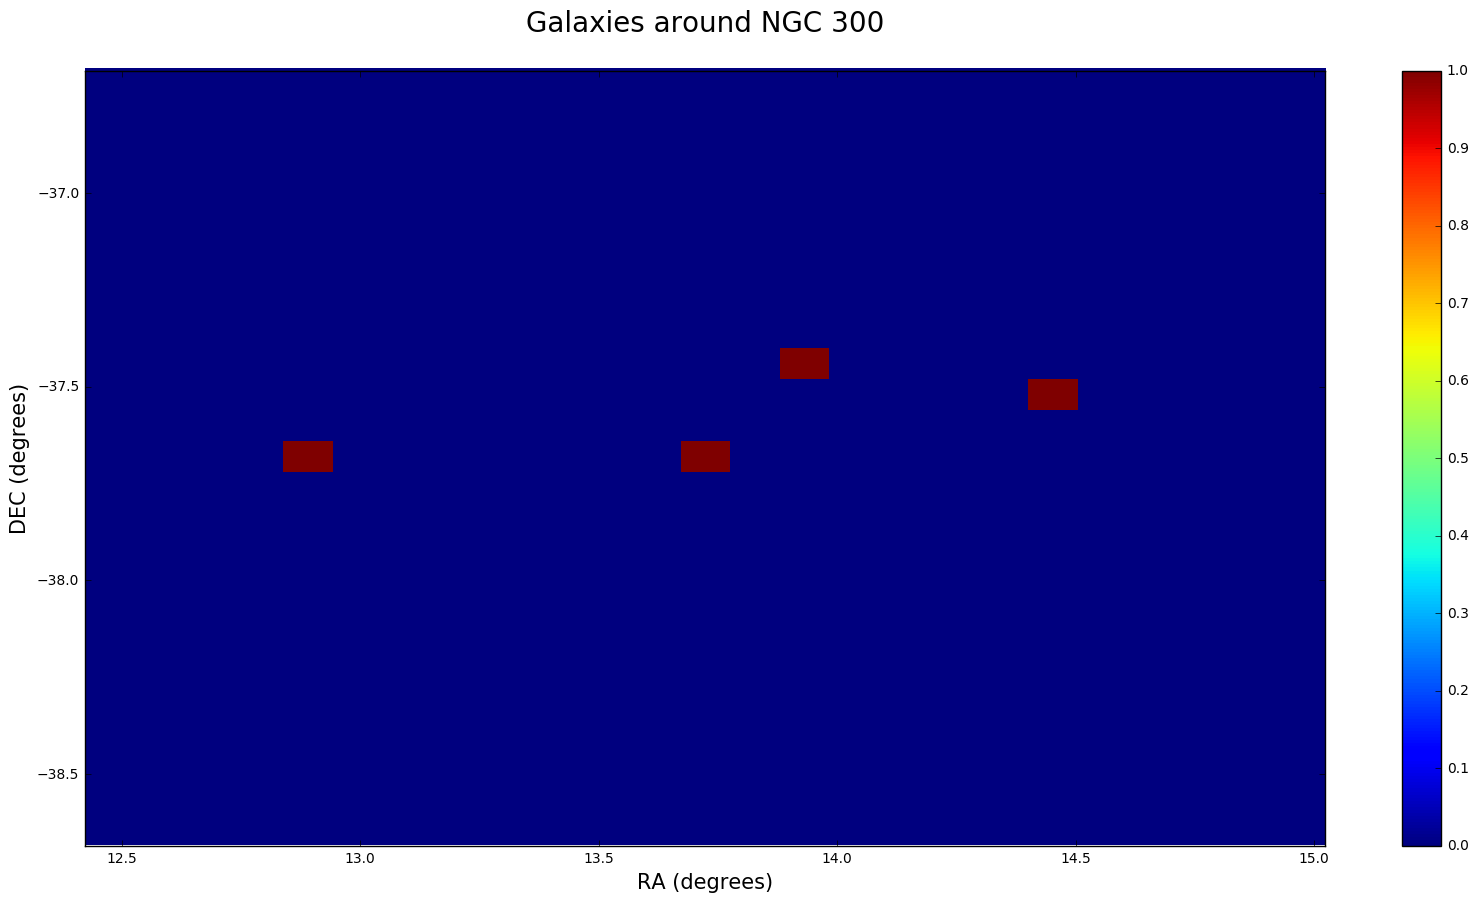

In [44]:
plt.figure(figsize=(20,10))
plt.hist2d(ra_in_view, dec_in_view, bins = 25, range=np.array([(min_ra, max_ra), (min_dec, max_dec)]))

plt.xlabel('RA (degrees)', fontsize = 15)
plt.ylabel('DEC (degrees)', fontsize = 15)
plt.title('Galaxies around NGC 300\n', fontsize = 20)
plt.xlim(min_ra, max_ra)
plt.ylim(min_dec, max_dec)
plt.colorbar()
plt.show()

In [37]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r) / pixarea
len(dp_dV)


31566

In [144]:
top50 = cat[np.flipud(np.argsort(dp_dV))][:50]
top50['_RAJ2000', '_DEJ2000', 'Ktmag']
print(type(top50))

<class 'astropy.table.table.Table'>


Here will we investigate the effects of cuts on redshift and magnitude and any other value on the number of candidates, letting 50mPc be the cutoff that we want the maximum number of cands to pass.

-23.9479363474


/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/student/student_i4/miniconda3/lib/python3.5/site-packages/astropy/cosmology/core.py:1414: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less_equal
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal


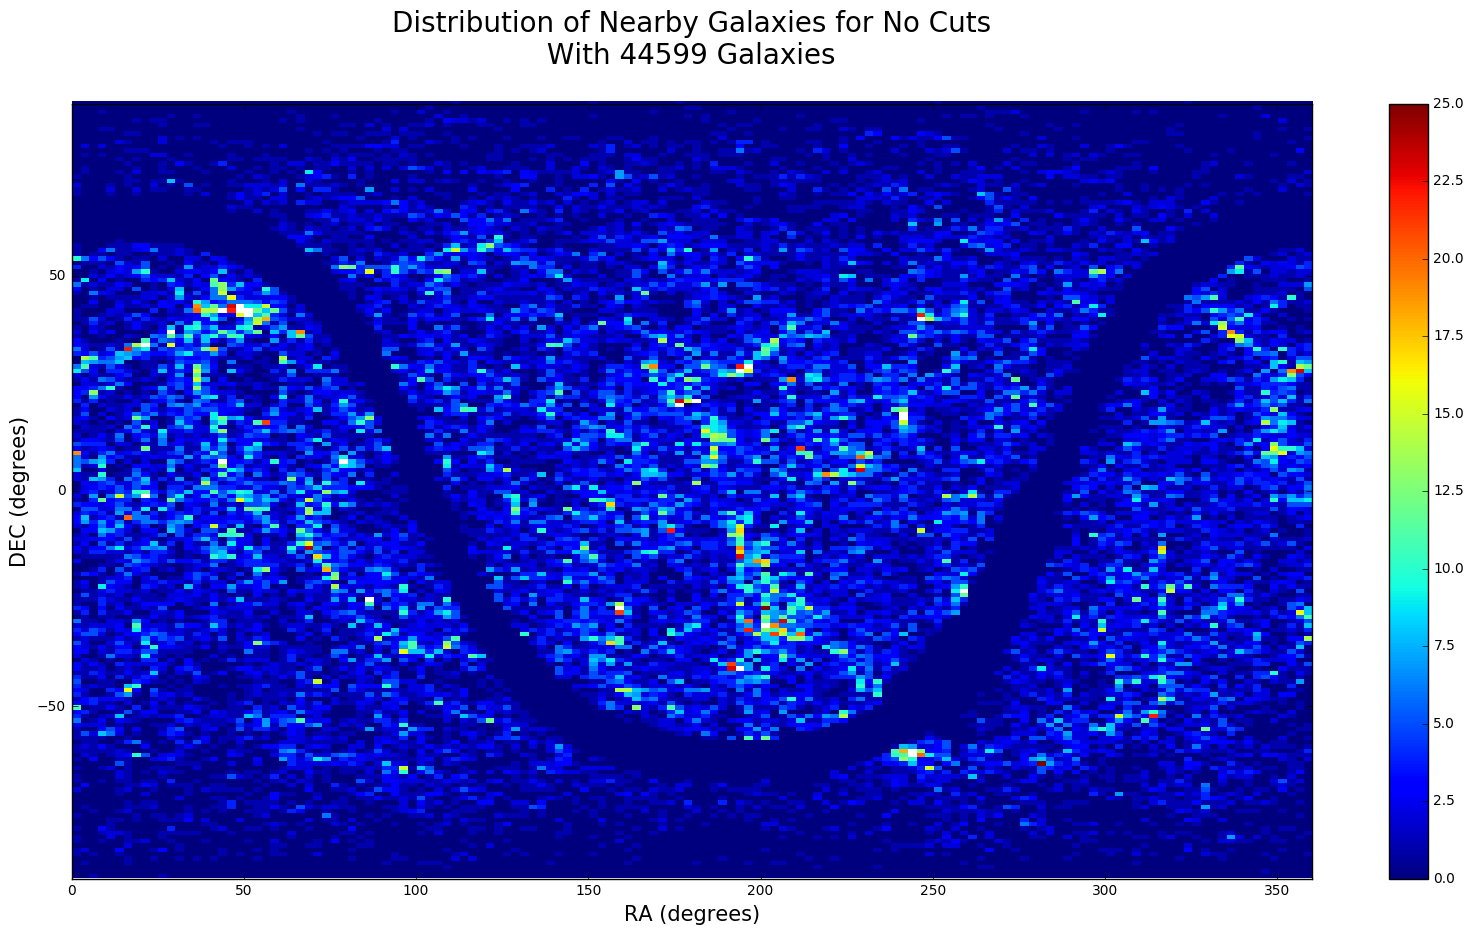

3924


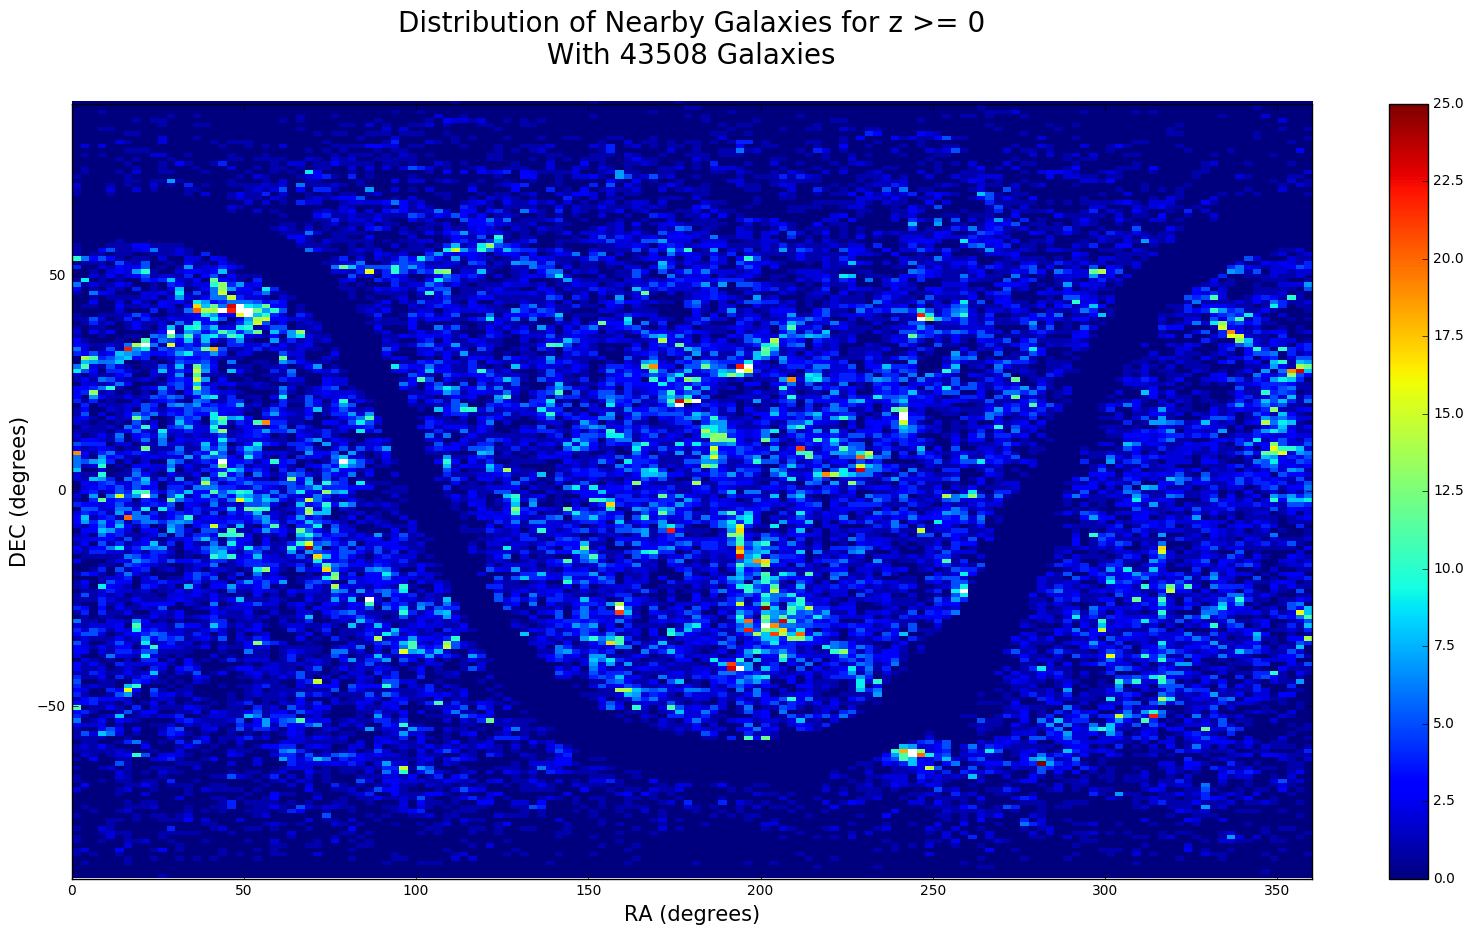

3899


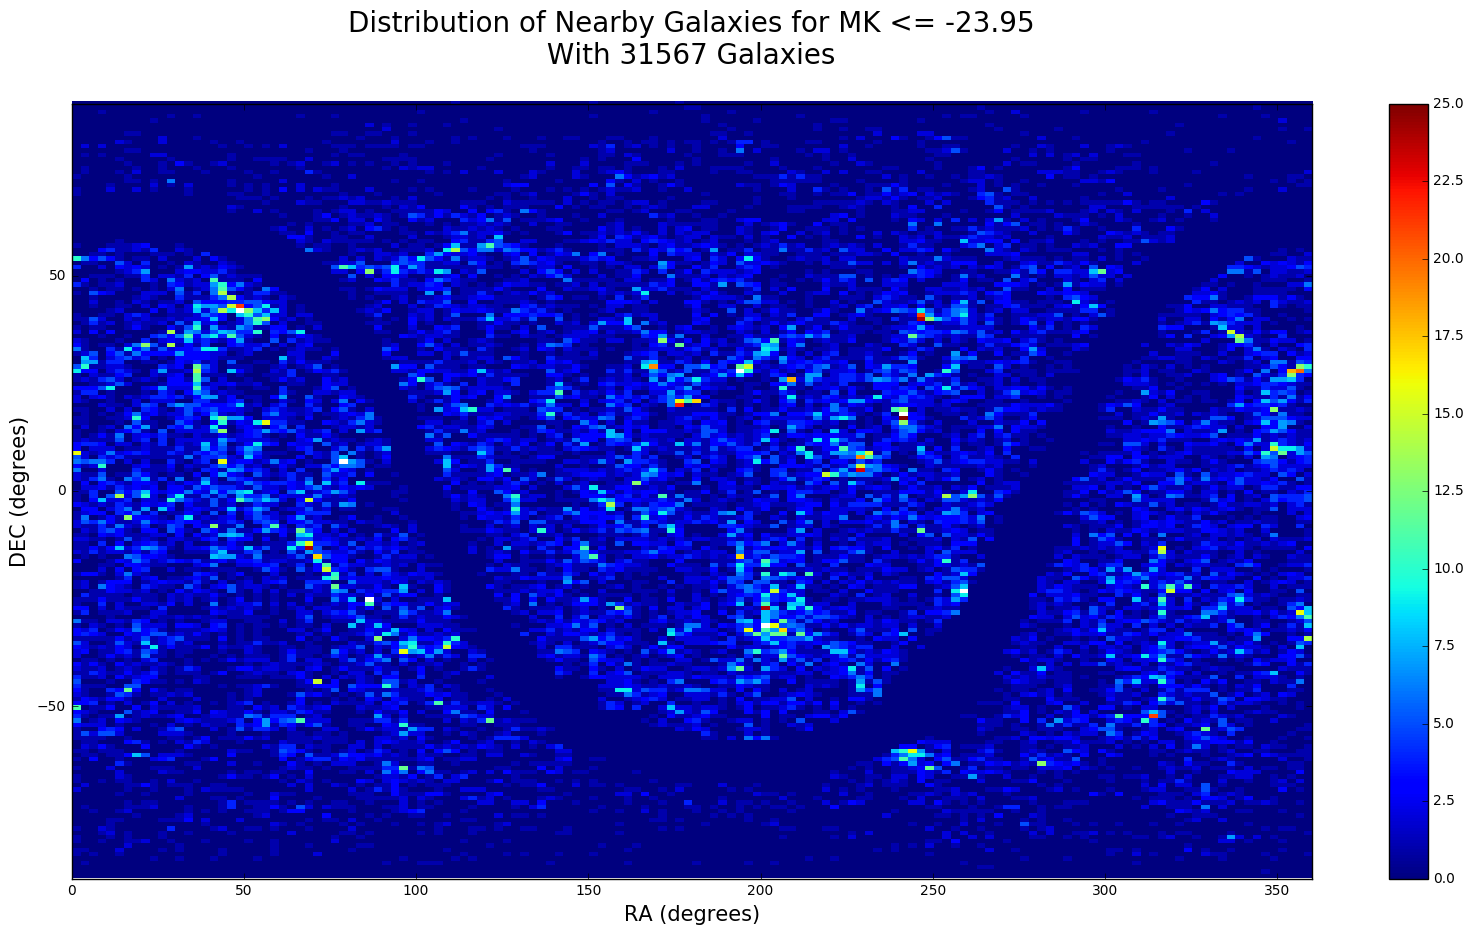

599


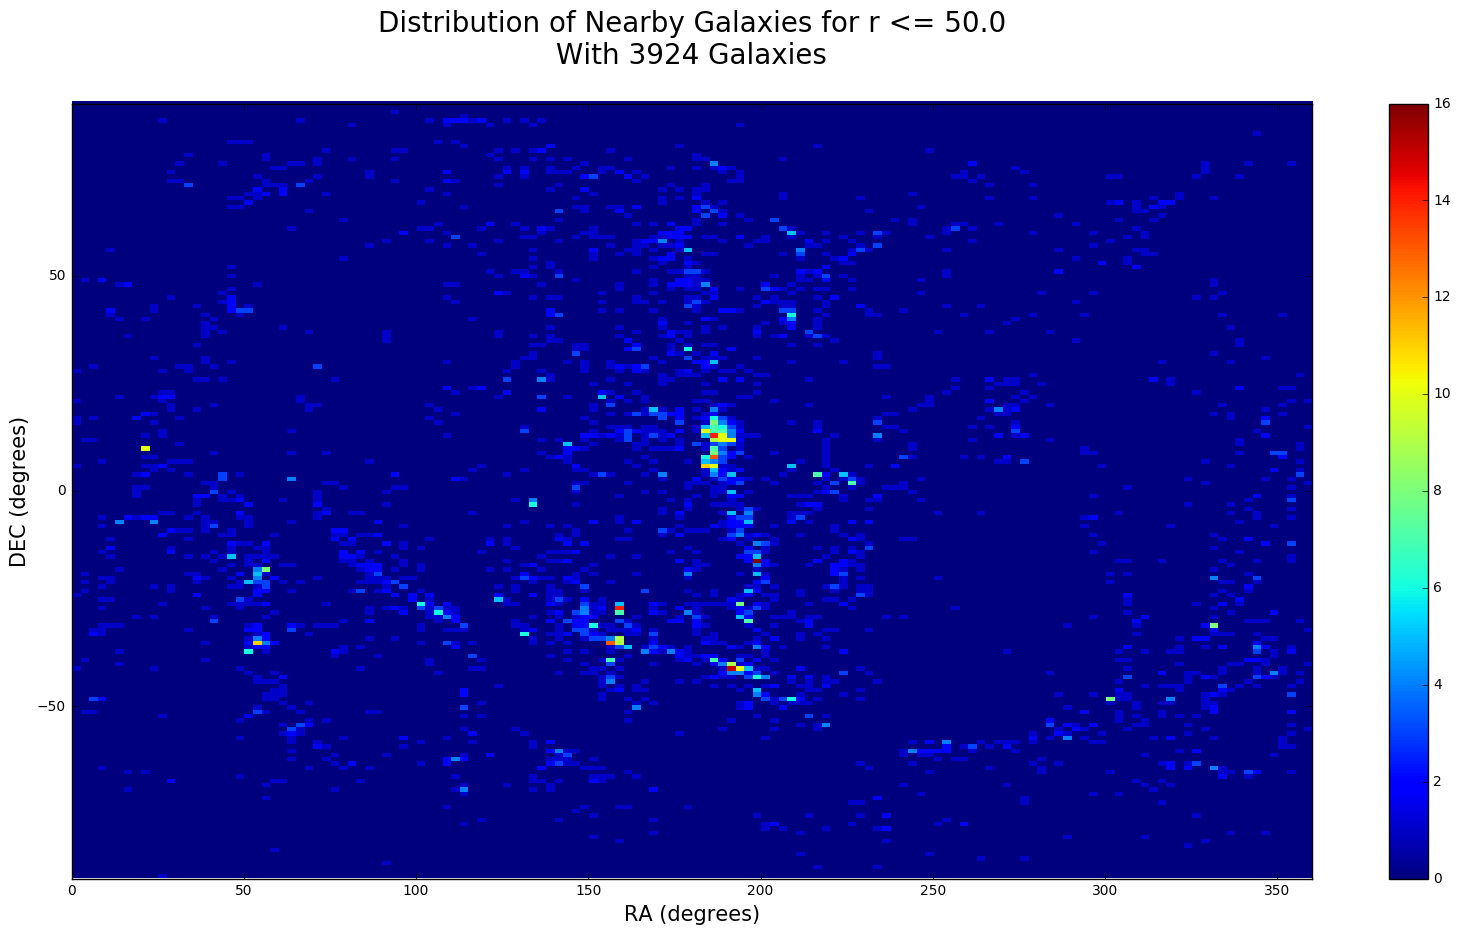

3924


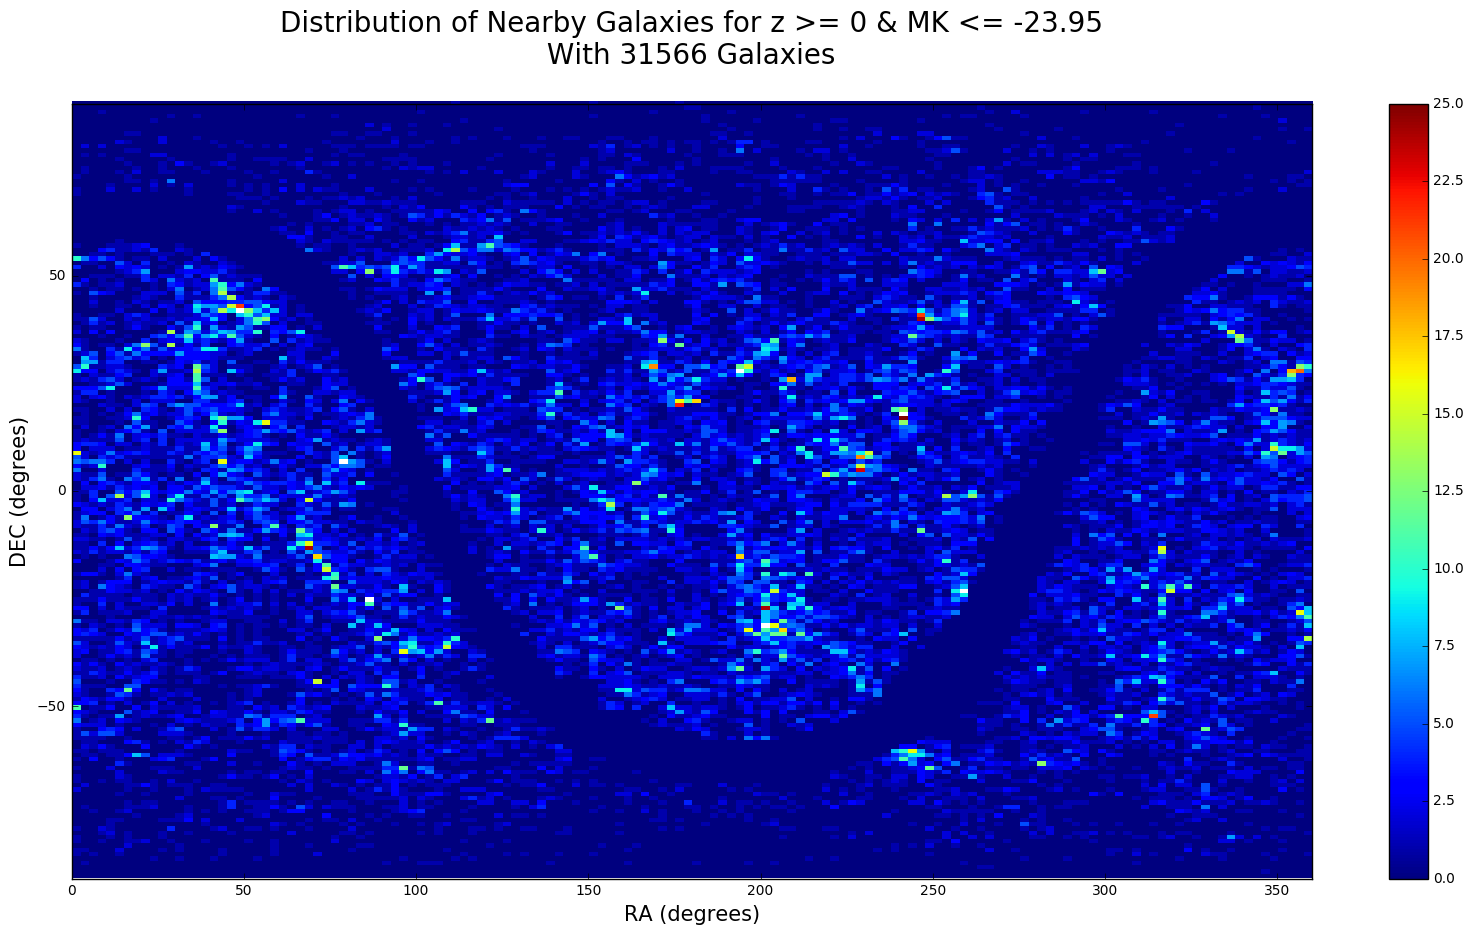

598


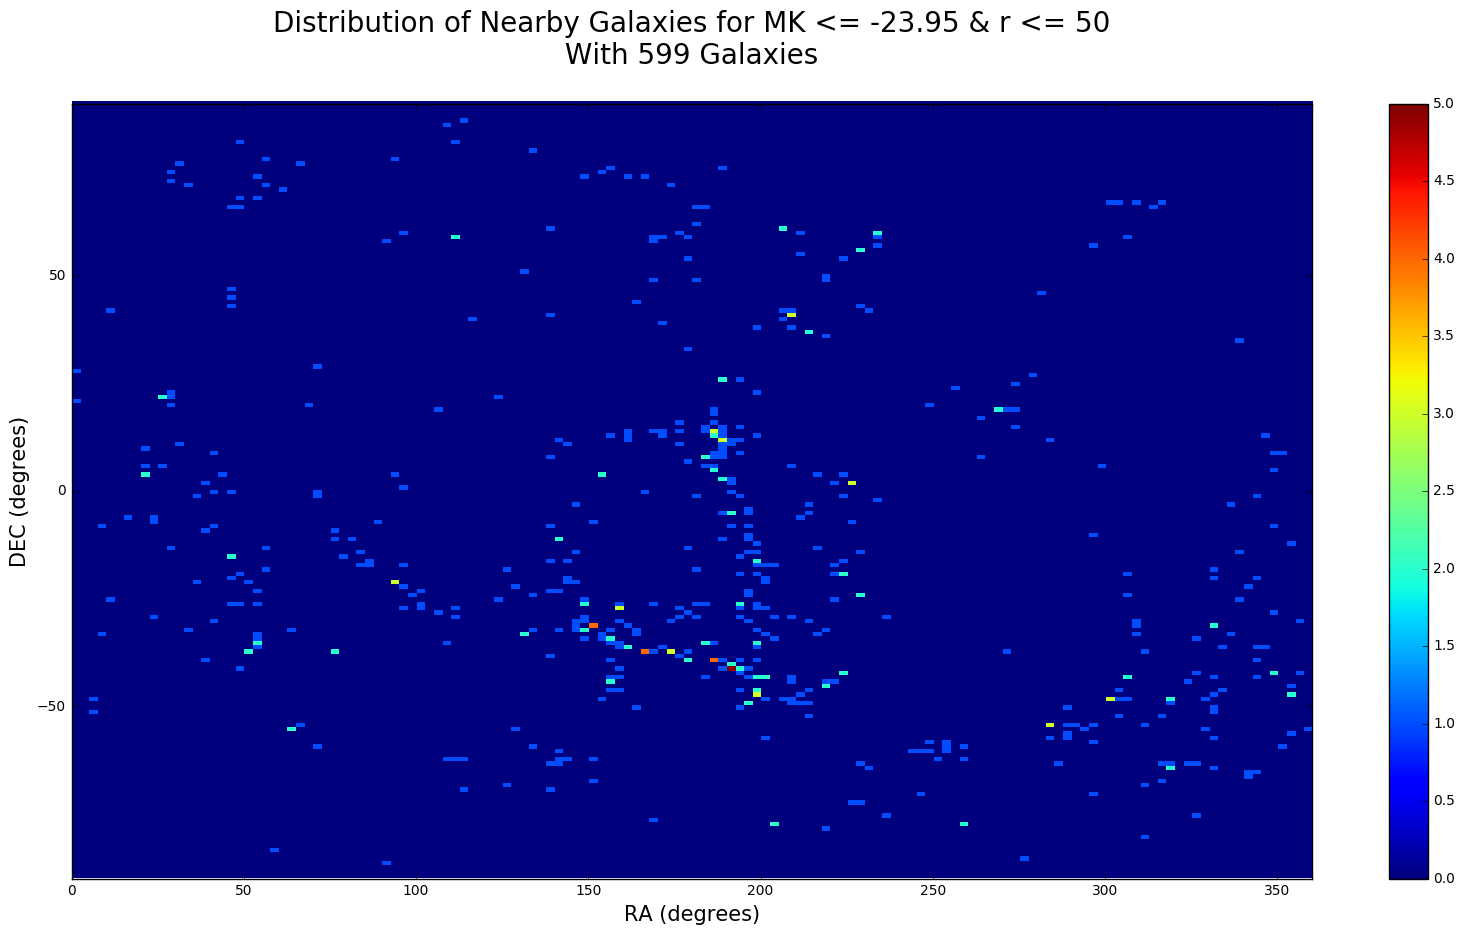

599


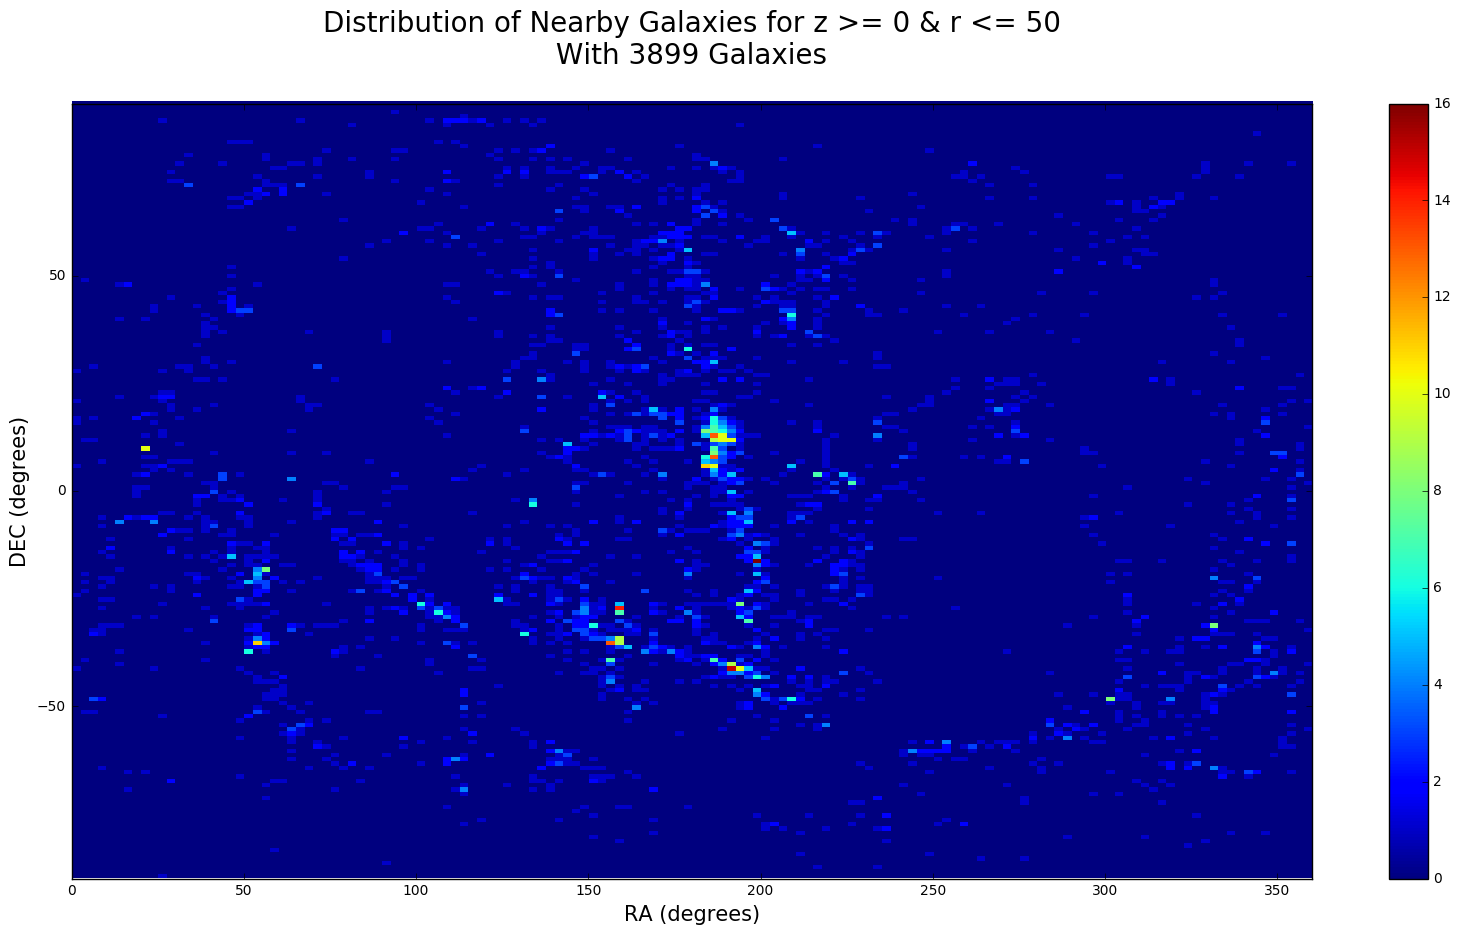

3899


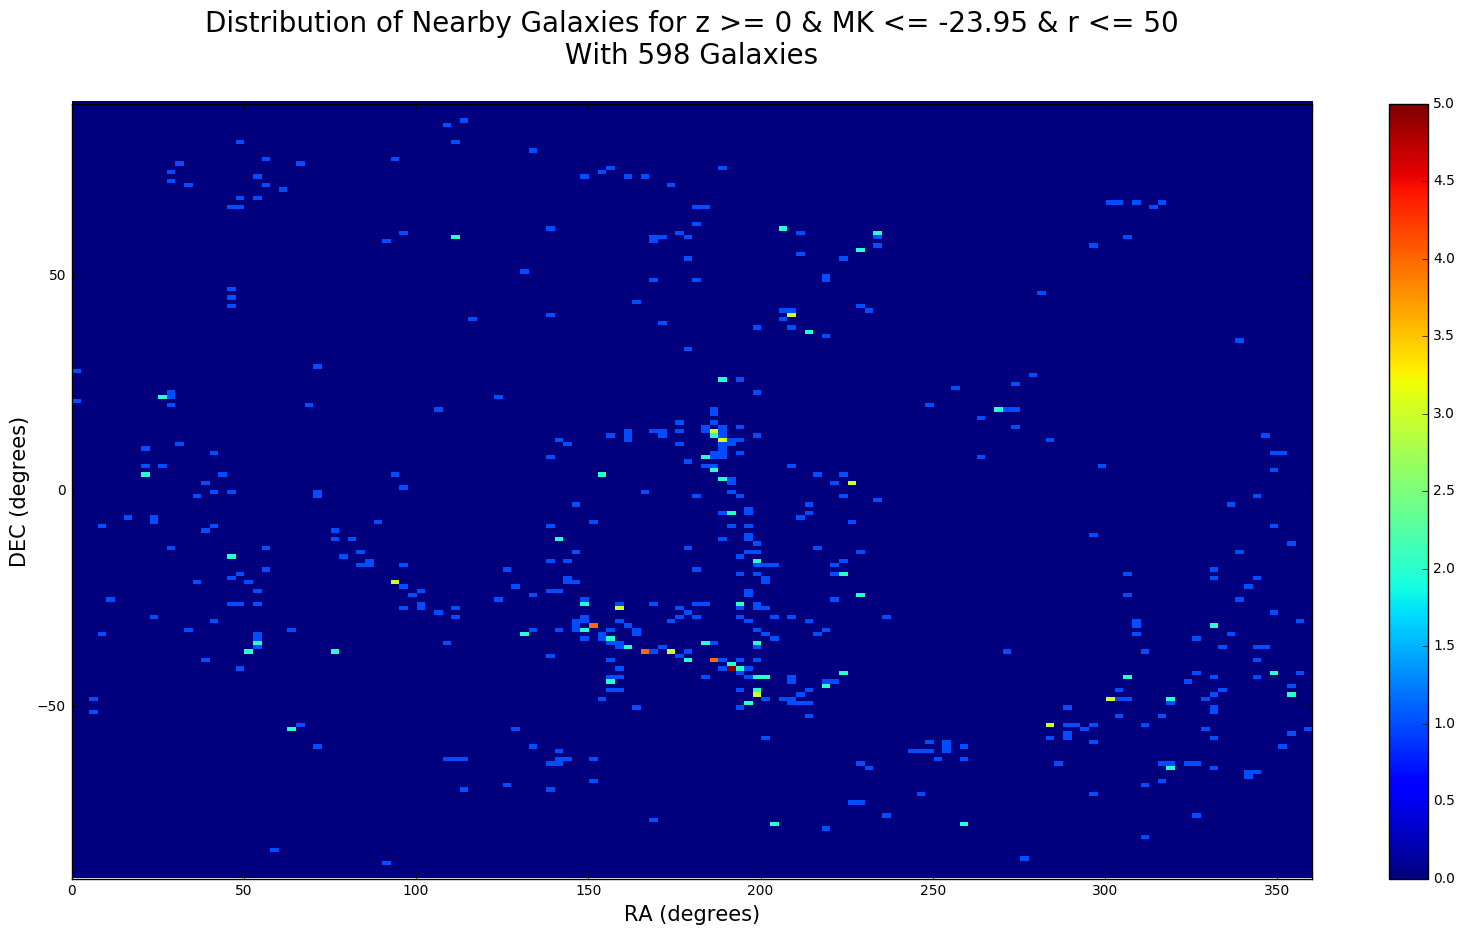

598


In [77]:
completeness = 0.5
alpha = -1.0
MK_star = -23.55
MK_max = MK_star + 2.5*np.log10(gammaincinv(alpha + 2, completeness))
print(MK_max)
z = (u.Quantity(cat['cz']) / c.c).to(u.dimensionless_unscaled)
MK = cat['Ktmag'] - cosmo.distmod(z)
r = cosmo.luminosity_distance(z).to('Mpc').value
keep_str = ['No Cuts', 'z >= 0', 'MK <= -23.95', 'r <= 50.0', 'z >= 0 & MK <= -23.95',
            'MK <= -23.95 & r <= 50', 'z >= 0 & r <= 50', 'z >= 0 & MK <= -23.95 & r <= 50']
keep = ['', (z>=0), (MK<=MK_max), (r<=50.0), (z >= 0) & (MK <= MK_max), (MK <= MK_max) & (r <= 50),
        (z >= 0) & (r <= 50), (z >= 0) & (MK <= MK_max) & (r <= 50)]
for k in range(len(keep)):
    if keep[k] is not '':
        cat_k = cat[keep[k]]
        z_k = z[keep[k]]
        r_k = r[keep[k]]
    else:
        cat_k = cat
        r_k = r
        z_k = z
    
    cords_ra = []
    cords_dec = []
    cords_dec_sin = []
    cords = []
    for cand in cat_k:
        cords_ra.append(float(cand['_RAJ2000']))
        cords_dec_sin.append(m.sin(m.radians(float(cand['_DEJ2000']))))
        cords_dec.append(float(cand['_DEJ2000']))
        cords.append([float(cand['_RAJ2000']), float(cand['_DEJ2000']), cand['SimbadName']])
        
    sin_dec = np.linspace(0,1,29)
    ra_deg = np.linspace(0,360,144)

    plt.figure(figsize=(20,10))
    plt.hist2d(cords_ra, cords_dec, bins = [144, 180],cmax=25, range=np.array([(0,360), (-90,90)]))

    plt.xlabel('RA (degrees)', fontsize = 15)
    plt.ylabel('DEC (degrees)', fontsize = 15)
    plt.title('Distribution of Nearby Galaxies for '+keep_str[k]+'\n With '+ str(len(cat_k)) + ' Galaxies \n'
              , fontsize = 20)
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.colorbar()
    plt.show()
    
    count = 0
    for j in range(len(r_k)):
        if r_k[j] <= 50.0:
            count = count+1
            
    print(count)

## Getting Candidates Per Sky Map

Here I want to use the sky map to filter the galaxy candidates. Then we can plot them and figure out how to tile regions.

In [70]:
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from matplotlib import pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Column
import astropy.units as u
import astropy.constants as c
from matplotlib import colors
import math as m
import numpy as np

from astropy.utils.data import download_file
url = ('https://dcc.ligo.org/P1500071/public/18869_bayestar.fits.gz')
filename = download_file(url, cache=True)

from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
cat, = Vizier.get_catalogs('J/ApJS/199/26/table3')
len(cat)

z = (u.Quantity(cat['cz']) / c.c).to(u.dimensionless_unscaled)
MK = cat['Ktmag'] - cosmo.distmod(z)

#prob = hp.read_map(filename)

#prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=range(4))

npix = len(prob)
print(npix)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)
pixarea

/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/student/student_i4/miniconda3/lib/python3.5/site-packages/astropy/cosmology/core.py:1414: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
3145728


3.994741635118857e-06

In [71]:
cat_now = cat
print(type(cat))



<class 'astropy.table.table.Table'>


/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


44599


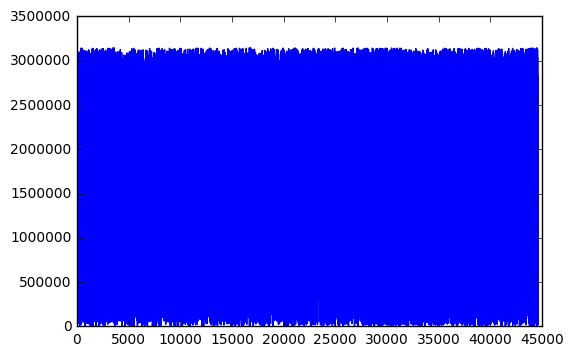

In [77]:
r = cosmo.luminosity_distance(z).to('Mpc').value
theta = 0.5*np.pi - cat_now['_DEJ2000'].to('rad').value
phi = cat_now['_RAJ2000'].to('rad').value
ipix = hp.ang2pix(nside, theta, phi)
print(len(ipix))
plt.plot(ipix)
plt.show()

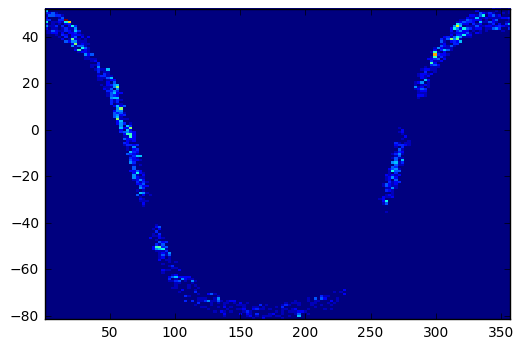

In [76]:
thet, ph = hp.pix2ang(nside, ipix)
ra = np.degrees(ph)[prob[ipix] >= np.percentile(prob[ipix],95)]
dec = np.degrees(thet-0.5*np.pi)[prob[ipix] >= np.percentile(prob[ipix],95)]

plt.hist2d(ra, dec, bins=[144,144], cmax=20)
plt.show()

In [74]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r) / pixarea
#dp_dV = prob[ipix]/pixarea

/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [92]:
foo = np.zeros(npix)

for i in range(len(ipix)):
    foo[ipix[i]]+=prob[ipix[i]]*distnorm[ipix[i]]*norm(distmu[ipix[i]], distsigma[ipix[i]]).pdf(r[i]) / pixarea

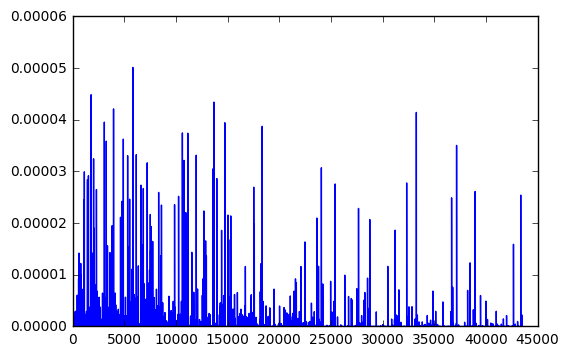

In [78]:
plt.plot(dp_dV)
plt.show()

/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal


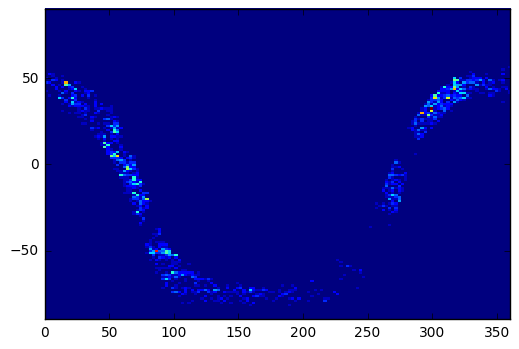

In [141]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r) / pixarea

thet, ph = hp.pix2ang(nside, ipix)
ra = np.degrees(ph)[dp_dV >= np.nanpercentile(dp_dV,95)]
dec = np.degrees(thet-0.5*np.pi)[dp_dV >= np.nanpercentile(dp_dV,95)]

plt.hist2d(ra, dec, bins=[144,144], cmax=20,range=np.array([(0,360), (-90,90)]))
plt.show()

In [125]:
from matplotlib import cm
afm_cmap = cm.summer
afm_cmap.set_under("w") # sets background to white

/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


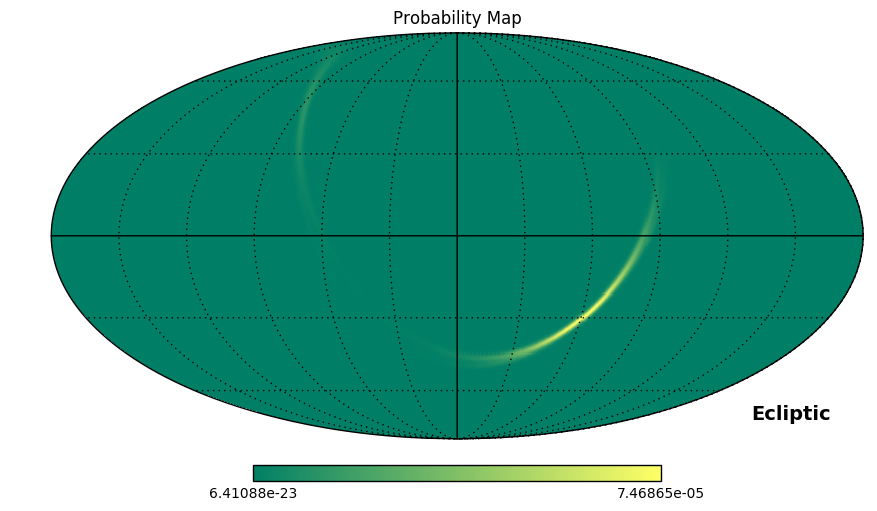

In [132]:
hp.mollview(prob, coord='E',
            title='Probability Map', cmap = afm_cmap)
            #, min=0,max=1, xsize=2000)
hp.graticule()

/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


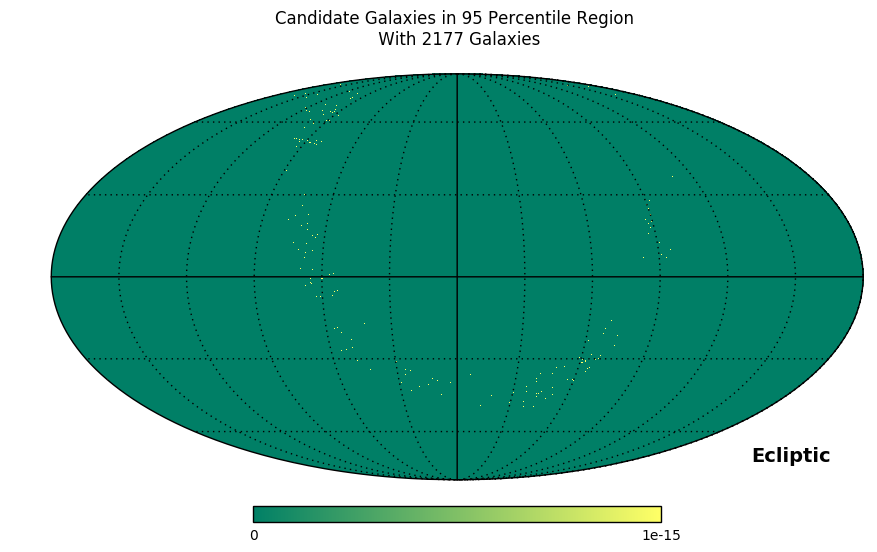

In [131]:
foo = np.where(foo >= np.nanpercentile(dp_dV,95), foo, 0)

hp.mollview(foo, coord='E',
            title='Candidate Galaxies in 95 Percentile Region \n With '
            + str(len(dp_dV[dp_dV>= np.nanpercentile(dp_dV,95)])) +' Galaxies\n',
            min=0,max=1e-15, xsize=2000, cmap = afm_cmap)
hp.graticule()

In [138]:
top50 = cat_now[dp_dV >= np.nanpercentile(dp_dV,95)]
top50['_RAJ2000', '_DEJ2000', 'Ktmag']

/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


_RAJ2000,_DEJ2000,Ktmag
deg,deg,mag
float64,float64,float32
41.57941,-30.27491,6.243
114.21415,65.60255,6.177
3.72334,-39.19663,6.244
54.71721,-26.33784,6.490
228.97369,56.32885,6.753
55.04960,-18.58038,6.678
226.62317,55.76331,6.868
54.62412,-23.02769,6.886


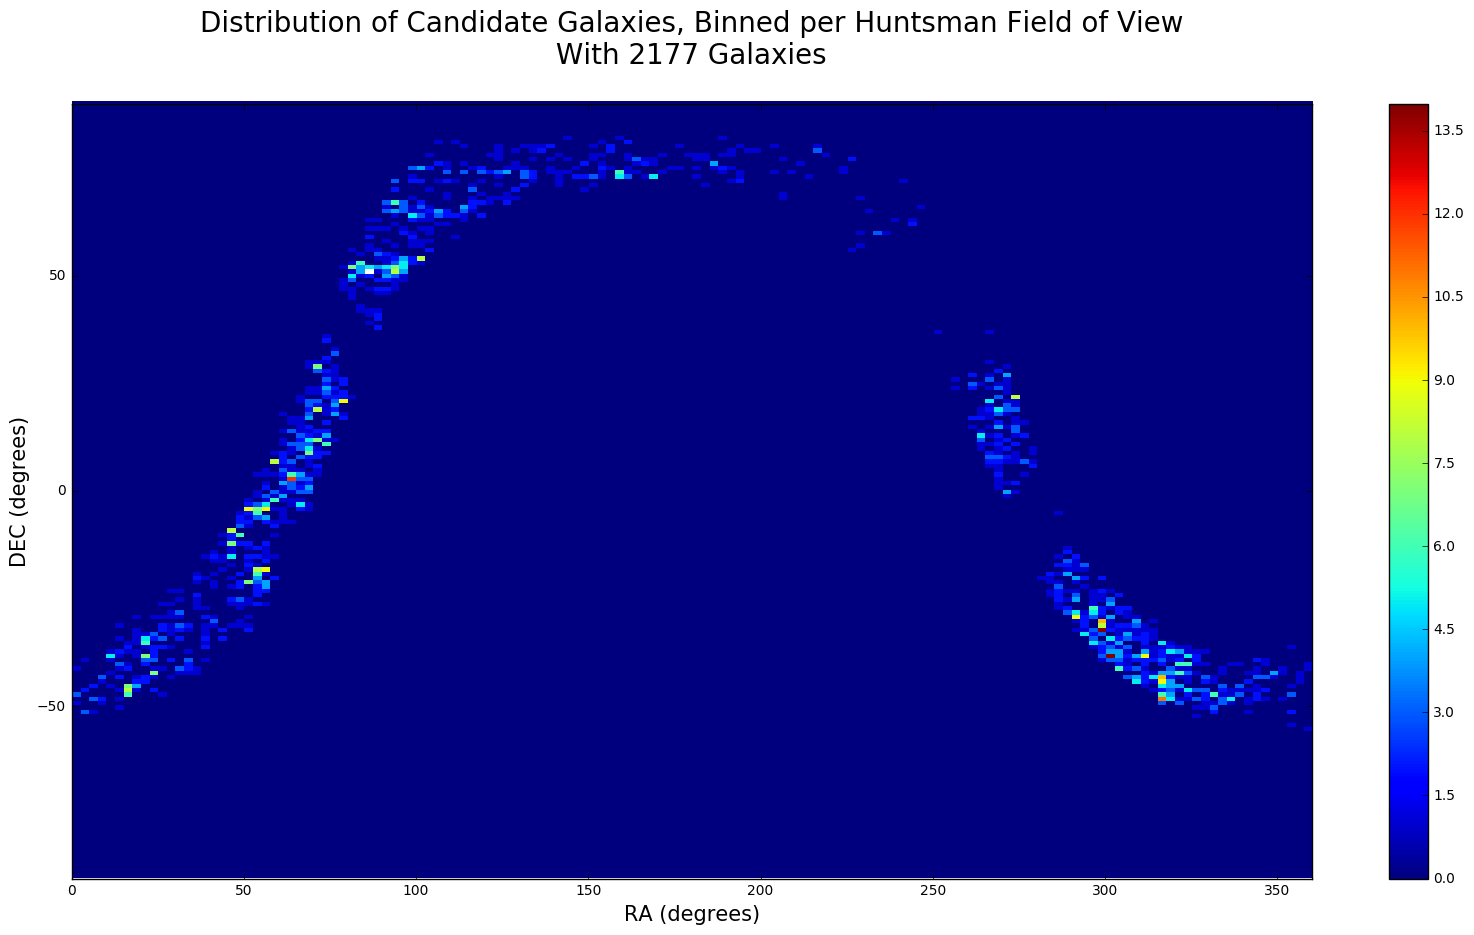

In [143]:
cords_ra = []
cords_dec = []
cords_dec_sin = []
cords = []
for cand in top50:
    cords_ra.append(float(cand['_RAJ2000']))
    cords_dec_sin.append(m.sin(m.radians(float(cand['_DEJ2000']))))
    cords_dec.append(float(cand['_DEJ2000']))
    cords.append([float(cand['_RAJ2000']), float(cand['_DEJ2000']), cand['SimbadName']])
    
plt.figure(figsize=(20,10))
plt.hist2d(cords_ra, cords_dec, bins = [144, 180],cmax=15, range=np.array([(0,360), (-90,90)]))

plt.xlabel('RA (degrees)', fontsize = 15)
plt.ylabel('DEC (degrees)', fontsize = 15)
plt.title('Distribution of Candidate Galaxies, Binned per Huntsman Field of View\n With '
          + str(len(top50))+' Galaxies \n', fontsize = 20)
plt.xlim(0, 360)
plt.ylim(-90, 90)
plt.colorbar()
plt.show()